In [1]:
from psg import PSG
import matplotlib.pyplot as plt
from importlib import reload
import numpy as np
import pandas as pd
import constants
from ecg import ECG
from emg import EMG
import eeg
from eeg import EEG
from eog import EOG
from sao2 import *
from matplotlib import pyplot as plt
from scipy import stats
import gc
import sklearn as sk
from sklearn import impute as skImpute
import seaborn as sns
from sklearn import preprocessing
from sklearn import metrics

In [ ]:
training_set_1 = ['ins2', 'ins6', 'n11', 'n2']
training_set_2 = ['nfle10', 'nfle11', 'nfle12', 'nfle13', 'nfle14', 'nfle15']
training_set_3 = ['plm10', 'plm1', 'plm2', 'plm3', 'plm5', 'plm6']
training_set_4 = ['rbd10', 'rbd11', 'rbd12', 'rbd13', 'rbd16', 'rbd17']

testing_set_1 = ['ins8', 'ins9', 'n5'] 
testing_set_2 = ['nfle16', 'nfle17', 'nfle18', 'nfle19'] 
testing_set_3 = ['plm7', 'plm8', 'plm9']
testing_set_4 = ['rbd18', 'rbd19', 'rbd20']

# Make sure you have the edf and txt files for each individual along with the GitHub modules.

for i in training_set_2:
    psg_data = PSG(i)

    #EEG Feature Extraction
    reload(eeg)
    EEG_columns = eeg.EEG(psg_data.data)
    EEG_columns.extract_features()
    eeg_data = EEG_columns.eeg_features

    #SAO2 Feature Extraction
    oxyData = psg_data.data[['epoch','SAO2']]
    sao2_data = SAO2(oxyData).get_SAO2_metrics()

    #EOG Feature Extraction
    eog_data = EOG(psg_data.data).get_EOG_metrics()

    #EMG Feature Extraction
    sxDfInput = psg_data.data.loc[:, ["elapsed_seconds", "epoch", "SX1-SX2"]]
    sx = EMG(sxDfInput, signalType = "SX1-SX2")
    sx_data = sx.getMetrics()

    dxDfInput = psg_data.data.loc[:, ["elapsed_seconds", "epoch", "DX1-DX2"]]
    dx = EMG(dxDfInput, signalType = "DX1-DX2")
    dx_data = dx.getMetrics()

    emgDfInput = psg_data.data.loc[:, ["elapsed_seconds", "epoch", "EMG1-EMG2"]]
    emg_columns = EMG(emgDfInput)
    emg_data = emg_columns.getMetrics()

    #ECG Feature Extraction
    ecgDfInput = psg_data.data.loc[:, ["epoch", "ECG1-ECG2"]]
    ecg_columns = ECG(ecgDfInput)
    ecg_data = ecg_columns.getMetrics()

    plethDfInput = psg_data.data.loc[:, ["elapsed_seconds", "epoch", "PLETH"]]
    pleth = ECG(plethDfInput, signalType = 'PLETH')
    pleth_data = pleth.getMetrics()

    #Combine and Export Data
    stage_1 = pd.merge(psg_data.txtData, eeg_data, how = 'left', on='epoch')
    stage_2 = pd.merge(stage_1, sao2_data, how = 'left', on='epoch')
    stage_3 = pd.merge(stage_2, eog_data, how = 'left', on='epoch')
    stage_4 = pd.merge(stage_3, sx_data, how = 'left', on='epoch')
    stage_5 = pd.merge(stage_4, dx_data, how = 'left', on='epoch')
    stage_6 = pd.merge(stage_5, emg_data, how = 'left', on='epoch')
    stage_7 = pd.merge(stage_6, ecg_data, how = 'left', on='epoch')
    final = pd.merge(stage_7, pleth_data, how = 'left', on='epoch')

    final.to_csv(i+'.csv')
    print(i+" successfully exported!")


In [2]:
allData = ['nfle10', 'nfle11', 'nfle12', 'nfle13', 'nfle14', 'nfle15','plm10', 'plm1', 'plm2', 'plm3', 'plm5', 'plm6','rbd10', 'rbd11', 'rbd12', 'rbd13', 'rbd16', 'rbd17', 'ins2', 'ins6', 'n11', 'n2']
firstNumericCol = 6 # Includes age

final = pd.DataFrame()

for dataset in allData: # Stuff in the loop is done on each dataset individually before combining
    thisData = pd.read_csv(dataset+'.csv')
    column_names = thisData.columns[firstNumericCol - 1:]

    # Add a patient column based on the file name so can be used to do groupby operations
    thisData.insert(1, "Patient", dataset)

    # Truncate based on shortest column before NaN's:
    lastNonNaNEachCol = thisData.notna()[::-1].idxmax()
    thisData = thisData.truncate(after = min(lastNonNaNEachCol))
    
    # Fill in missing data using KNN
    impute_KNN = thisData.iloc[:, firstNumericCol:]
    imputer = skImpute.KNNImputer(n_neighbors = 4, weights = "uniform")
    thisData.iloc[:, firstNumericCol:] = imputer.fit_transform(impute_KNN)

    # Combine with full dataset
    if final.empty:
        final = thisData
    else:
        final = pd.concat([final, thisData])
    
# Drop current "_norm" cols:
for col in final.columns:
    if "_norm" in col:
        final.drop(col, axis=1, inplace=True)

# Normalize (Divide by average within same patient):
for patient in final["Patient"].unique():
    thisPatientMeans = final[final["Patient"] == patient].iloc[:, firstNumericCol:].mean()
    final[final["Patient"] == patient].iloc[:, firstNumericCol:] /= thisPatientMeans
    
#Box-Cox
for column in final.columns[firstNumericCol:]:
    try:
        final[column] = final[column].abs()
        box_cox_trans = stats.boxcox(final[column])[0]
        final[column] = box_cox_trans
    except:
        continue
    #normalized = ((box_cox_trans-box_cox_trans.mean())/box_cox_trans.std())
    #final[column] = (box_cox_trans-box_cox_trans.min())/(box_cox_trans.max()-box_cox_trans.min())
    
print("Box-Cox completed.")  

#Robust Scaling
subset1 = final.iloc[:,:firstNumericCol]
subset2 = final.iloc[:,firstNumericCol:]

scaler = preprocessing.RobustScaler() # By default, centers and scales
robust_df = scaler.fit_transform(subset2)
final.iloc[:, firstNumericCol:] = robust_df
#robust_df = pd.DataFrame(robust_df, columns = column_names)
print("Robust Scaling completed.")

# #Box-Cox
# for column in final.columns[firstNumericCol:]:
#     final[column] = final[column].abs()
#     box_cox_trans = stats.boxcox(final[column] + 1e-16)[0]
#     final[column] = box_cox_trans
#     #normalized = ((box_cox_trans-box_cox_trans.mean())/box_cox_trans.std())
#     #final[column] = (box_cox_trans-box_cox_trans.min())/(box_cox_trans.max()-box_cox_trans.min())
    
# print("Box-Cox completed.")     

#Encoding (Sleep Stage)
final.drop("Unnamed: 0", axis=1, inplace=True)

final.insert(2, "sleep_stage", np.zeros(len(final)))

for stage in constants.SLEEP_STAGES:
    final.loc[final["Sleep Stage"] == stage, "sleep_stage"] = constants.SLEEP_STAGES.get(stage)

final.drop("Sleep Stage", axis=1, inplace=True)

# Encoding (Condition)
conditionColumns = pd.DataFrame()
for patient in pd.unique(final['Patient']):
    thisPatientSeries = (final[final['Patient'] == patient])["condition"]
    thisPatientDf = thisPatientSeries.to_frame("condition")
    for condition in constants.CONDITION_TO_BINARY:
        if condition == thisPatientDf.at[0, 'condition']:
            binary = constants.CONDITION_TO_BINARY.get(condition)

            if binary[0] == 0:
                thisPatientDf.insert(1, "condition_0", np.zeros(len(thisPatientDf)))
            else:
                thisPatientDf.insert(1, "condition_0", np.ones(len(thisPatientDf)))

            if binary[1] == 0:
                thisPatientDf.insert(2, "condition_1", np.zeros(len(thisPatientDf)))
            else:
                thisPatientDf.insert(2, "condition_1", np.ones(len(thisPatientDf)))

            if binary[2] == 0:
                thisPatientDf.insert(3, "condition_2", np.zeros(len(thisPatientDf)))
            else:
                thisPatientDf.insert(3, "condition_2", np.ones(len(thisPatientDf)))

            if binary[3] == 0:
                thisPatientDf.insert(4, "condition_3", np.zeros(len(thisPatientDf)))
            else:
                thisPatientDf.insert(4, "condition_3", np.ones(len(thisPatientDf)))
    
    if conditionColumns.empty:
        conditionColumns = thisPatientDf[["condition_0", "condition_1", "condition_2", "condition_3"]]
    else: # ConditionColumns already initialized
        conditionColumns = pd.concat([conditionColumns, thisPatientDf[["condition_0", "condition_1", "condition_2", "condition_3"]]])
final.insert(5, "rbd", conditionColumns["condition_0"])
final.insert(6, "ins", conditionColumns["condition_1"])
final.insert(7, "nfle", conditionColumns["condition_2"])
final.insert(8, "plm", conditionColumns["condition_3"])

final.drop("condition", axis=1, inplace=True)

print('Encoding completed.')


#Robust Scaling
#subset1 = final.iloc[:,:firstNumericCol]
#subset2 = final.iloc[:,firstNumericCol:]

#scaler = preprocessing.RobustScaler() # By default, centers and scales
#robust_df = scaler.fit_transform(subset2)
#robust_df = pd.DataFrame(robust_df, columns = column_names)
#print("Robust Scaling done for " + dataset)

#Export
#final = pd.concat([subset1, robust_df], axis = 1)
final.reset_index(inplace=True)
final = final.iloc[:,1:]
final.to_csv('final.csv')
print('Dataset successfully exported!')

/Users/Ashok/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1717: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/Users/Ashok/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Box-Cox completed.
Robust Scaling completed.
Encoding completed.
Dataset successfully exported!


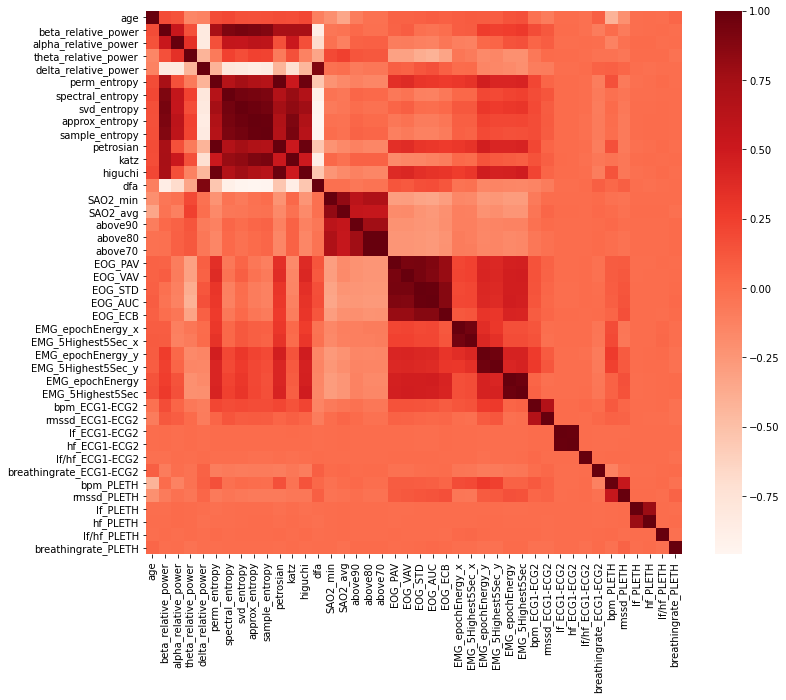

                Feature A             Feature B      Corr
50              petrosian          perm_entropy  0.999747
170               above70               above80  0.998883
560          hf_ECG1-ECG2          lf_ECG1-ECG2  0.991405
44         sample_entropy        approx_entropy  0.990244
252               EOG_AUC               EOG_STD  0.986913
76                higuchi             petrosian  0.978680
71                higuchi          perm_entropy  0.976268
35         approx_entropy           svd_entropy  0.973796
434      EMG_5Highest5Sec       EMG_epochEnergy  0.969425
377    EMG_5Highest5Sec_y     EMG_epochEnergy_y  0.964952
86                    dfa        approx_entropy  0.958954
324    EMG_5Highest5Sec_x     EMG_epochEnergy_x  0.952039
27            svd_entropy      spectral_entropy  0.949300
43         sample_entropy           svd_entropy  0.947339
87                    dfa        sample_entropy  0.946254
85                    dfa           svd_entropy  0.938926
229           

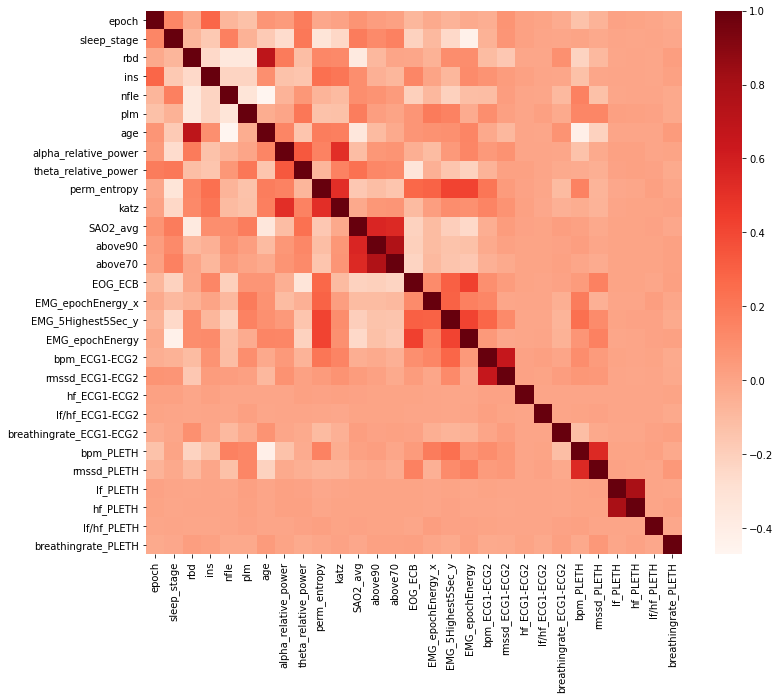

In [3]:
# Feature Removal Based on Between-Feature Correlation:

## INPUTS ##:
threshold = 0.8 # Abs correlation above which feature is removed

# 1. Calculate Correlation Matrix of the Predictors
columnsToCorr = list(final.columns)
safeFeatures = ['Patient', 'epoch', 'sleep_stage', 'rbd', 'ins', 'nfle', 'plm'] # Features that we won't remove
for i in safeFeatures:
    columnsToCorr.remove(i)

plt.figure(figsize=(12,10))
cor = final[columnsToCorr].corr()
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
plt.show()

# 2. Determine the two predictors associated with the largest absolute pairwise correlation
# Remove (set = 0) half of the matrix because symmetric:
lowerTriangleMask = np.tril(np.ones(cor.shape), -1).astype(np.bool) # Create lower triangle mask
corLowerTriangle = cor.where(lowerTriangleMask)
corAbs = corLowerTriangle.abs() # Consider absolute correlation

# Build sorted dataframe of form: ["Feature A", "Feature B", corr]
pairwiseCorr = corAbs.stack().reset_index()
pairwiseCorr.columns = ['Feature A','Feature B','Corr']

# Isolate correlations to remove
pairwiseCorr = pairwiseCorr[pairwiseCorr['Corr'] > threshold]
pairwiseCorr.sort_values('Corr', ascending = False, inplace = True)
print(pairwiseCorr)

# 3. Determine the average correlation between A and B and every other feature:
# Create an average correlation dataframe of form [feature, averageCorr]
averageCorr = pd.DataFrame(cor.abs().mean(axis = 1), cor.index, ['avgCorr'])

# Loop through pairwiseCorr, make a list of features to remove. 
featuresToRemove = []
for index, row in pairwiseCorr.iterrows():
    featureA = row['Feature A']
    featureB = row['Feature B']
    featureA_avgCorr = averageCorr.loc[featureA, 'avgCorr']
    featureB_avgCorr = averageCorr.loc[featureB, 'avgCorr']

    # If A has larger average correlation, remove it. Otherwise, remove B
    if featureA_avgCorr >= featureB_avgCorr:
        if featureA not in featuresToRemove:
            featuresToRemove.append(featureA)
    else:
        if featureB not in featuresToRemove:
            featuresToRemove.append(featureB)

# Report results:
print("Threshold: " + str(threshold))
print(featuresToRemove)

# Dataset with features removed
correlationFeatureRemoval = final.drop(featuresToRemove, axis = 1)
print("Remaining Features: " + str(correlationFeatureRemoval.shape[1]))

# Show the correlation matrix after feature removal
plt.figure(figsize=(12,10))
cor2 = correlationFeatureRemoval.corr()
sns.heatmap(cor2, annot=False, cmap=plt.cm.Reds)
plt.show()
    

In [4]:
print(averageCorr)
print(averageCorr.loc["above70", "avgCorr"])

                          avgCorr
age                      0.135883
beta_relative_power      0.289870
alpha_relative_power     0.204048
theta_relative_power     0.176014
delta_relative_power     0.267096
perm_entropy             0.327339
spectral_entropy         0.290230
svd_entropy              0.304706
approx_entropy           0.297450
sample_entropy           0.293552
petrosian                0.328004
katz                     0.261537
higuchi                  0.335233
dfa                      0.287483
SAO2_min                 0.198309
SAO2_avg                 0.173976
above90                  0.159852
above80                  0.170972
above70                  0.170654
EOG_PAV                  0.252999
EOG_VAV                  0.253700
EOG_STD                  0.260186
EOG_AUC                  0.260248
EOG_ECB                  0.224773
EMG_epochEnergy_x        0.152886
EMG_5Highest5Sec_x       0.163078
EMG_epochEnergy_y        0.255141
EMG_5Highest5Sec_y       0.241346
EMG_epochEnerg

In [5]:
# Feature Selection with Mutual Information

info_selection = pd.concat([correlationFeatureRemoval['sleep_stage'], correlationFeatureRemoval.iloc[:, 9:]], axis=1)

safe_features = list(correlationFeatureRemoval.iloc[:, :9].columns)

info_scores = []

for x in info_selection.columns[1:]:
    score = metrics.normalized_mutual_info_score(info_selection['sleep_stage'], info_selection[x])
    column_and_score = (x, score)
    info_scores.append(column_and_score)
    
target_columnscore = pd.DataFrame(info_scores).sort_values(by=1, ascending = False)

top_5_cols = safe_features+list(target_columnscore[0][:5])
top_10_cols = safe_features+list(target_columnscore[0][:10])
top_20_cols = safe_features+list(target_columnscore[0][:20])
top_30_cols = safe_features+list(target_columnscore[0][:30])

top_5_data = correlationFeatureRemoval[top_5_cols]
top_10_data = correlationFeatureRemoval[top_10_cols]
top_20_data = correlationFeatureRemoval[top_20_cols]
top_30_data = correlationFeatureRemoval[top_30_cols]

print(target_columnscore)

                          0         1
8         EMG_epochEnergy_x  0.280715
2              perm_entropy  0.280713
3                      katz  0.280713
7                   EOG_ECB  0.280713
10          EMG_epochEnergy  0.280713
0      alpha_relative_power  0.280713
9        EMG_5Highest5Sec_y  0.280713
1      theta_relative_power  0.280713
17              rmssd_PLETH  0.280680
19                 hf_PLETH  0.280602
16                bpm_PLETH  0.279704
20              lf/hf_PLETH  0.279370
18                 lf_PLETH  0.279222
12          rmssd_ECG1-ECG2  0.278584
11            bpm_ECG1-ECG2  0.275692
13             hf_ECG1-ECG2  0.273916
14          lf/hf_ECG1-ECG2  0.269483
15  breathingrate_ECG1-ECG2  0.157553
4                  SAO2_avg  0.116675
21      breathingrate_PLETH  0.048631
6                   above70  0.033367
5                   above90  0.027169
